# ML for HPC Runtime Prediction




## Install the dependencies


In [18]:
!pip install pandas scikit-learn torch

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Load the cluster data

In [20]:
from google.colab import files

uploaded = files.upload()
csv = list(uploaded.keys())[0]

print("Model will use: ", csv)

Saving clusterData.csv to clusterData (1).csv
Model will use:  clusterData (1).csv


In [21]:
df = pd.read_csv(csv, sep = ",")
print(df.columns)


# Look at the valid jobs from the data
df = df[df["state"] == "COMPLETED"]
df = df[df["run_time"] > 0]
df = df.dropna(subset=["wallclock_req","nodes_req", "processors_req", "gpus_req", "mem_req", "run_time" ])

featureCols = ["wallclock_req","nodes_req", "processors_req", "gpus_req", "mem_req"]
targetCol = "run_time"

xGraph = df[featureCols].values.astype("float32")
yGraph = df[targetCol].values.astype("float32")

print("X: ", xGraph.shape)
print("Y: ", yGraph.shape)

df[featureCols + [targetCol]].head()



Index(['job_id', 'user', 'account', 'partition', 'qos', 'wallclock_req',
       'nodes_req', 'processors_req', 'gpus_req', 'mem_req', 'submit_time',
       'start_time', 'end_time', 'run_time', 'state', 'name', 'work_dir',
       'submit_line'],
      dtype='object')
X:  (985, 5)
Y:  (985,)


,wallclock_req,nodes_req,processors_req,gpus_req,mem_req,run_time
0,172800.0,10,10,0,0.0,99825.0
1,172800.0,10,10,0,0.0,97235.0
2,172800.0,10,10,0,0.0,130861.0
3,172800.0,10,10,0,0.0,100392.0
4,172800.0,10,10,0,0.0,101587.0


In [22]:

x_train, x_test, y_train, y_test = train_test_split(xGraph, yGraph, test_size=0.2, random_state=42)

print("Training X: ", x_train.shape)
print("Test X: ", x_test.shape)
print("Training Y: ", y_train.shape)
print("Test Y: ", y_test.shape)

Training X:  (788, 5)
Test X:  (197, 5)
Training Y:  (788,)
Test Y:  (197,)


In [23]:
scaled = StandardScaler()

scaledTrainingX = scaled.fit_transform(x_train)
scaledTestX = scaled.transform(x_test)

print(scaledTrainingX.shape, scaledTestX.shape)


(788, 5) (197, 5)


# Linear Regression Model


In [24]:
linReg = LinearRegression()
linReg.fit(scaledTrainingX, y_train)

yTrainPred = linReg.predict(scaledTrainingX)
yTestPred = linReg.predict(scaledTestX)

def evaluate(name, yTrue, yPred):
  mae = mean_absolute_error(yTrue, yPred)
  rmse = mean_squared_error(yTrue, yPred)
  r2 = r2_score(yTrue, yPred)
  print("Mean Absolute Error: ", mae)
  print("Mean Squared Error: ", rmse)
  print("R^2: ", r2)

print("TRAINING")
evaluate("Linear Train", y_train, yTrainPred)
print("--------------------")

print("TEST")
evaluate("Linear Test", y_test, yTestPred)
print("--------------------")



TRAINING
Mean Absolute Error:  4000.029541015625
Mean Squared Error:  82009896.0
R^2:  0.41919875144958496
--------------------
TEST
Mean Absolute Error:  4039.4111328125
Mean Squared Error:  81926440.0
R^2:  0.5250277519226074
--------------------


# Neural Network


In [25]:
xTrainTensor = torch.from_numpy(scaledTrainingX).float()
xTestTensor = torch.from_numpy(scaledTestX).float()

yTrainTensor = torch.from_numpy(y_train).float().unsqueeze(1)
yTestTensor = torch.from_numpy(y_test).float().unsqueeze(1)

trainingDS = TensorDataset(xTrainTensor, yTrainTensor)
testDS = TensorDataset(xTestTensor, yTestTensor)

trainLoader = DataLoader(trainingDS, batch_size=256, shuffle = True)
testLoader = DataLoader(testDS, batch_size=256, shuffle = False)







In [26]:
inputDimension = xTrainTensor.shape[1]

class NeuralNetwork(nn.Module):
  def __init__(self, inputDimension):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(inputDimension, 64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
  def forward(self, x):
    return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork(inputDimension).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)




In [27]:
# start the training loop

epochs = 4000

# store the losses to show graph later
losses = []

for epoch in range(1, epochs + 1):
  model.train()
  modelLoss = 0.0

  for xBatch, yBatch in trainLoader:
    xBatch = xBatch.to(device)
    yBatch = yBatch.to(device)

    optimizer.zero_grad()
    preds = model(xBatch)
    loss = criterion(preds, yBatch)
    loss.backward()
    optimizer.step()

    modelLoss += loss.item() * xBatch.size(0)

  averageTrainingLoss = modelLoss / len(trainingDS)
  losses.append(averageTrainingLoss)
  print(f"Epoch {epoch} | Train MSE: {averageTrainingLoss: .2f}")




Epoch 1 | Train MSE:  218989209.50
Epoch 2 | Train MSE:  218987880.93
Epoch 3 | Train MSE:  218986645.36
Epoch 4 | Train MSE:  218985239.23
Epoch 5 | Train MSE:  218983850.23
Epoch 6 | Train MSE:  218982221.64
Epoch 7 | Train MSE:  218980652.35
Epoch 8 | Train MSE:  218978872.28
Epoch 9 | Train MSE:  218977006.86
Epoch 10 | Train MSE:  218975000.08
Epoch 11 | Train MSE:  218972706.15
Epoch 12 | Train MSE:  218970201.99
Epoch 13 | Train MSE:  218967374.13
Epoch 14 | Train MSE:  218964086.09
Epoch 15 | Train MSE:  218960377.46
Epoch 16 | Train MSE:  218956186.60
Epoch 17 | Train MSE:  218951512.28
Epoch 18 | Train MSE:  218946399.31
Epoch 19 | Train MSE:  218940613.20
Epoch 20 | Train MSE:  218934130.03
Epoch 21 | Train MSE:  218926555.37
Epoch 22 | Train MSE:  218918337.62
Epoch 23 | Train MSE:  218909864.00
Epoch 24 | Train MSE:  218900269.20
Epoch 25 | Train MSE:  218890150.82
Epoch 26 | Train MSE:  218879010.56
Epoch 27 | Train MSE:  218866695.59
Epoch 28 | Train MSE:  218853878.90
E

In [28]:
# evalute the model using the previous method

model.eval()

train_true = []
train_pred = []


with torch.no_grad():
  for xb, yb in trainLoader:
    xb = xb.to(device)
    preds = model(xb).cpu().numpy()
    train_pred.append(preds)
    train_true.append(yb.numpy())

train_true = np.vstack(train_true).ravel()
train_pred = np.vstack(train_pred).ravel()


test_true = []
test_pred = []


with torch.no_grad():
  for xb, yb in testLoader:
    xb = xb.to(device)
    preds = model(xb).cpu().numpy()
    test_pred.append(preds)
    test_true.append(yb.numpy())

test_true = np.vstack(test_true).ravel()
test_pred = np.vstack(test_pred).ravel()

evaluate("Neural Network Training:", train_true, train_pred)
evaluate("Neural Network Test:", test_true, test_pred)



Mean Absolute Error:  1561.8145751953125
Mean Squared Error:  50622864.0
R^2:  0.6414844393730164
Mean Absolute Error:  1774.1817626953125
Mean Squared Error:  52638620.0
R^2:  0.6948251724243164


## Figures


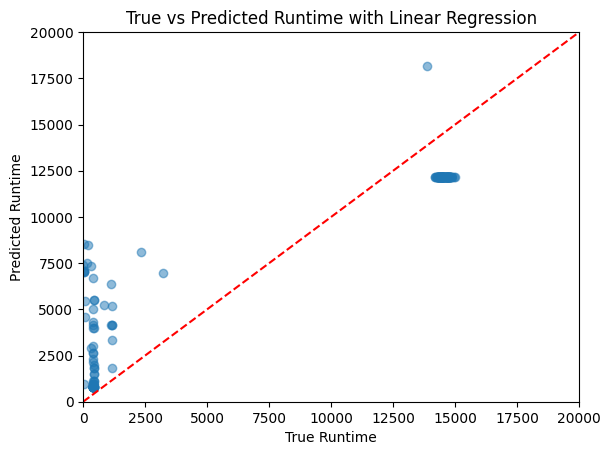

In [29]:
# linear Regression Figure

plt.scatter(y_test, yTestPred, alpha=0.5)

# Most jobs are between 0 and 20,000 seconds, so we zoom here to see difference between models
minimum = 0
maximum = 20000

plt.plot([minimum, maximum], [minimum, maximum], 'r--')
plt.xlim(minimum, maximum)
plt.ylim(minimum, maximum)

plt.xlabel("True Runtime")
plt.ylabel("Predicted Runtime")
plt.title("True vs Predicted Runtime with Linear Regression")
plt.show()

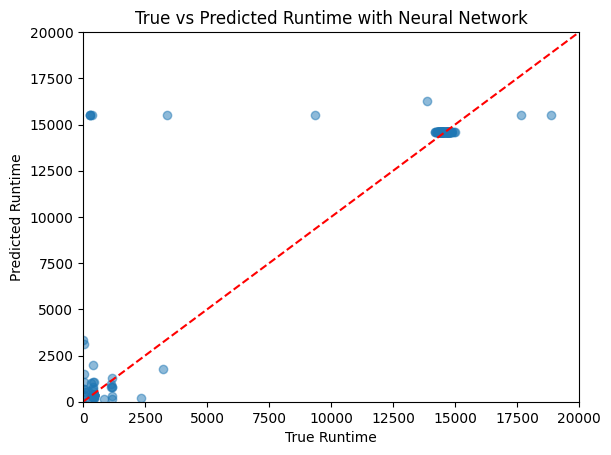

In [30]:
# Figures for NN performance

nnTestPred = model(xTestTensor.to(device)).detach().cpu().numpy()

plt.scatter(y_test, nnTestPred, alpha=0.5)

# zoom into where most jobs are between (0 and 20,000 seconds)
minimum = 0
maximum = 20000

plt.plot([minimum, maximum], [minimum, maximum], 'r--')
plt.xlim(minimum, maximum)
plt.ylim(minimum, maximum)

plt.xlabel("True Runtime")
plt.ylabel("Predicted Runtime")
plt.title("True vs Predicted Runtime with Neural Network")
plt.show()

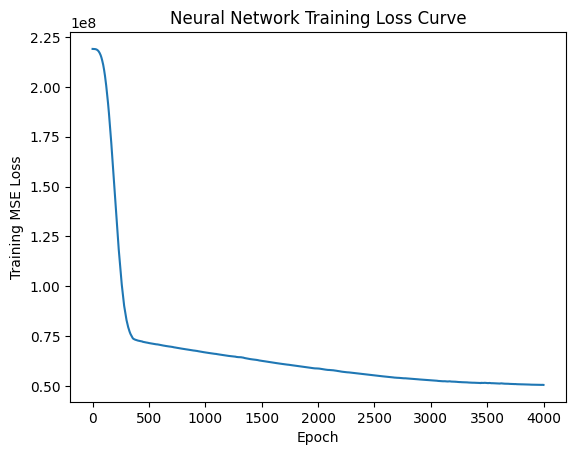

In [31]:
# loss graph

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training MSE Loss")
plt.title("Neural Network Training Loss Curve")
plt.show()


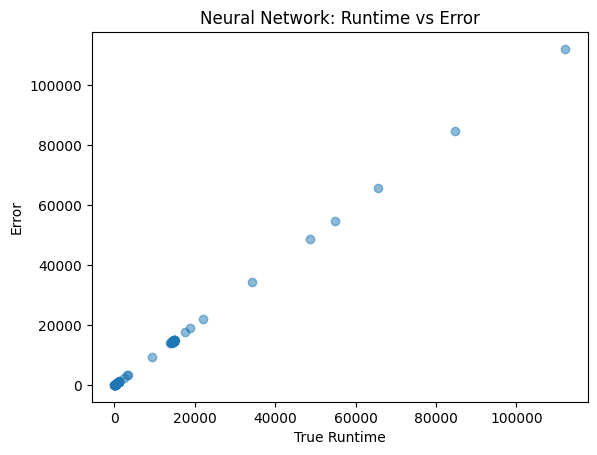

In [32]:
nnTestPredFlatt = nnTestPred.reshape(-1)

errors = np.abs(y_test, nnTestPredFlatt)

plt.scatter(y_test, errors, alpha=0.5)
plt.xlabel("True Runtime")
plt.ylabel("Error")
plt.title("Neural Network: Runtime vs Error")
plt.show()